In [157]:
import plotly.express as px
import plotly.io as pio
pio.templates.default = "simple_white"
colorscale = px.colors.sequential.Plasma
colorscale = [colorscale[0]] + colorscale[3:8]

#for no gaps between histogram bars:
#fig.update_traces(marker_line_width=0) 
#fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#plotly libraries
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio

import os
import pandas as pd
import numpy as np
from Bio import SeqIO

#default renderer (svg means very small file size, visibility on github, high quality, but requires sometimes setting height and width)
#pio.renderers.default = "jupyterlab"
pio.renderers.default = "svg"
colors = ["#363b3d", "#727b76", "#31a240", "#f93939", "#f79118", "#de7b06", "#9b308f", "#dc759b"]
#additional defaults
px.defaults.color_discrete_sequence = ["rgb(100,100,100)"] + pc.qualitative.D3
px.defaults.width=1000
px.defaults.height=500

#set default template as "simple_white" (no background, no grid lines)
pio.templates["simple_white"].layout["yaxis"]["showgrid"] = True
pio.templates["simple_white"].layout["xaxis"]["showgrid"] = True
pio.templates.default = "simple_white"

In [159]:
#use an excel (xlsx) sheet for samples, with required columns "Sample" and "barcode", samples must not contain spaces
data_folder = f"{os.getcwd()}/data"

samplesheet = pd.read_excel("./Samplesheet_example.xlsx", engine="openpyxl")
samplesheet

,sample,sequencing run,barcode
0,Nanopore_HIV1_Rep1_RT-US_0mM_cell,Run1,barcode01
1,Nanopore_HIV1_Rep1_RT-US_57mM_cell,Run1,barcode05
2,Nanopore_HIV1_Rep1_RT-US_85mM_cell,Run1,barcode06
3,Nanopore_HIV1_Rep2_RT-US_0mM_cell,Run2,barcode01
4,Nanopore_HIV1_Rep2_RT-US_57mM_cell,Run2,barcode05
5,Nanopore_HIV1_Rep2_RT-US_85mM_cell,Run2,barcode06
6,Nanopore_HIV1_Rep1_RT-FS_0mM_cell,Run1,barcode21
7,Nanopore_HIV1_Rep1_RT-FS_57mM_cell,Run1,barcode25
8,Nanopore_HIV1_Rep1_RT-FS_85mM_cell,Run1,barcode26
9,Nanopore_HIV1_Rep2_RT-FS_0mM_cell,Run2,barcode21


In [160]:
def get_combined_sample(sample):
    return "_".join(sample.split("_")[3:5]) # adjust to naming scheme

In [161]:
# Here we set a minimum read count filter to ensuree that we don't run analysis on isoforms with 0 reads. 
# This does not generally need to be tuned, as the evaluation for which isoforms have enough coverage comes later with 
# correlation between replicates
read_counts_df = pd.read_pickle(f"{data_folder}/isoquant/read_counts.pickle")

In [162]:
per_replicate_df = pd.pivot(read_counts_df, index = ["RT_and_DMS", "isoform_id"], columns = "replicate", values = "count").reset_index()
per_replicate_df = per_replicate_df.loc[~((per_replicate_df['RT_and_DMS'].str.contains("FS")) & (per_replicate_df["isoform_id"] == "RT1_unspliced1")),:]

min_cov = 200
min_cov_df = per_replicate_df[(per_replicate_df["Rep1"] > min_cov) & (per_replicate_df["Rep2"] > min_cov)]
combined_samples_for_isoform = min_cov_df.groupby("isoform_id").agg({"RT_and_DMS" : list}).to_dict()["RT_and_DMS"]

replicate,RT_and_DMS,isoform_id,Rep1,Rep2
141,RT-US_0mM,RT1_unspliced1,33675.0,92092.0
173,RT-US_57mM,RT1_unspliced1,46055.0,62781.0
207,RT-US_85mM,RT1_unspliced1,70941.0,87262.0


In [164]:
import numpy as np

isoforms = list(combined_samples_for_isoform.keys())
print(f"Detected {len(isoforms)} unique isoforms throughout all samples with coverage above {min_cov}")

Detected 29 unique isoforms throughout all samples with coverage above 200


## Read in reactivityt data from previously exported csv files 
(alternatively may be read in from xml files)

In [167]:
import numpy as np
from Bio import SeqIO
data = []

option = "q22_eq10_ndni"
reactive_nt = "AC"
norm_option=""

for isoform in isoforms:
    isoform_samples = combined_samples_for_isoform[isoform]
    
    for sample in isoform_samples:
        reactivity_file = f"{data_folder}/rfcombine/{sample}/{isoform}/{option}_{reactive_nt}{norm_option}/{isoform}.csv"
        try:
            reactivity = np.loadtxt(f"{reactivity_file}").astype("float")
        except:
            continue
        for record in SeqIO.parse(f"references/transcripts_PCR1_2_3/{isoform}.fa", "fasta"):
            sequence = list(record.seq)
        data.append(
        {
            "sample" : sample,
            "DMS_conc" : sample.split("_")[1],
            "RT" : sample.split("_")[0],
            "isoform" : isoform,
            "reactivity" : reactivity,
            "sequence" :sequence,
            "rc_option" : option,
            "reactive_nt" : reactive_nt,
            "norm_option" : norm_option
        }
        )

In [ ]:
df = pd.DataFrame(data)

# Reactivity heatmap with clustering

In [169]:
from seaborn import clustermap
import matplotlib.pyplot as plt

In [170]:
figure_dir = f"{os.getcwd()}/figures/reactivities"
os.makedirs(figure_dir, exist_ok=True)

In [171]:
corr_df = pd.read_pickle(f"{data_folder}/rfcombine/corr_df.pickle")

In [173]:
df = pd.merge(df, corr_df, left_on = ["sample", "isoform", "reactive_nt", "norm_option", "rc_option"], right_on = ["sample", "isoform", "reactive_nt", "norm_option", "rc_option"], how="left")

In [174]:
len(df)

50

In [175]:
filtered_df = df[df["pearson_corr"] >= 0.9]

In [176]:
len(filtered_df)

22

## Cluster reactivities by similarity (across constant region, e.g. first 289 nt) and plot sorted heatmaps

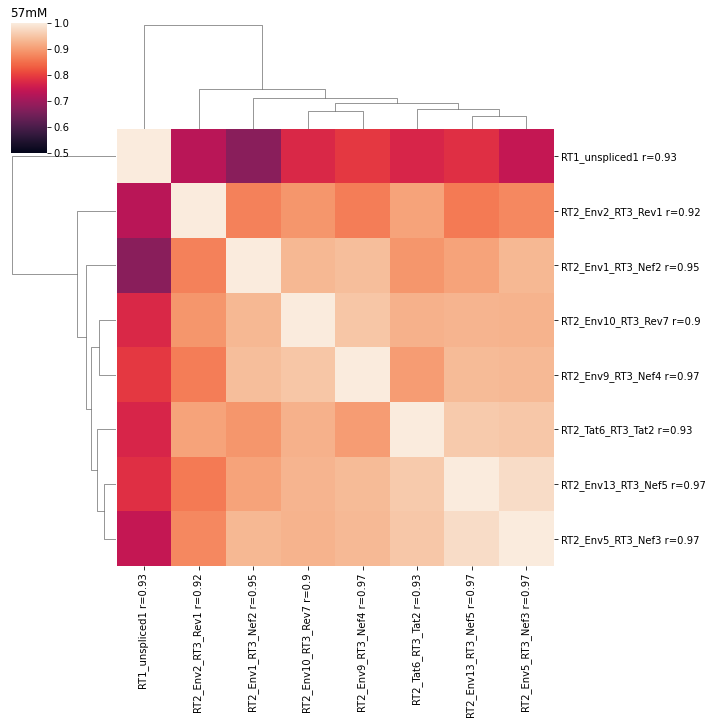

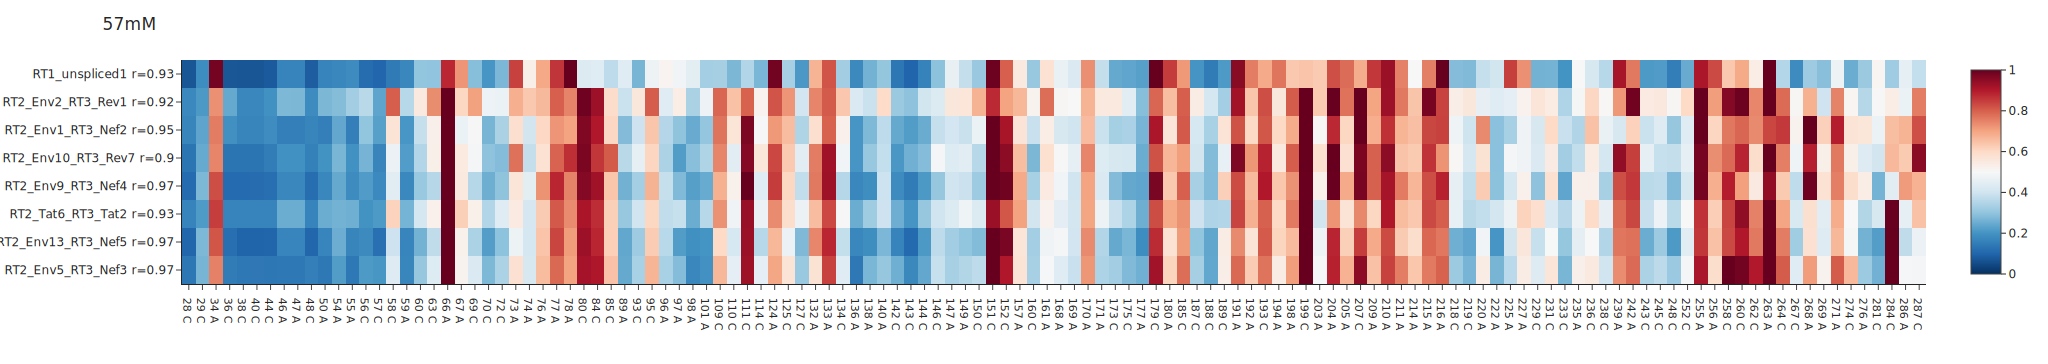

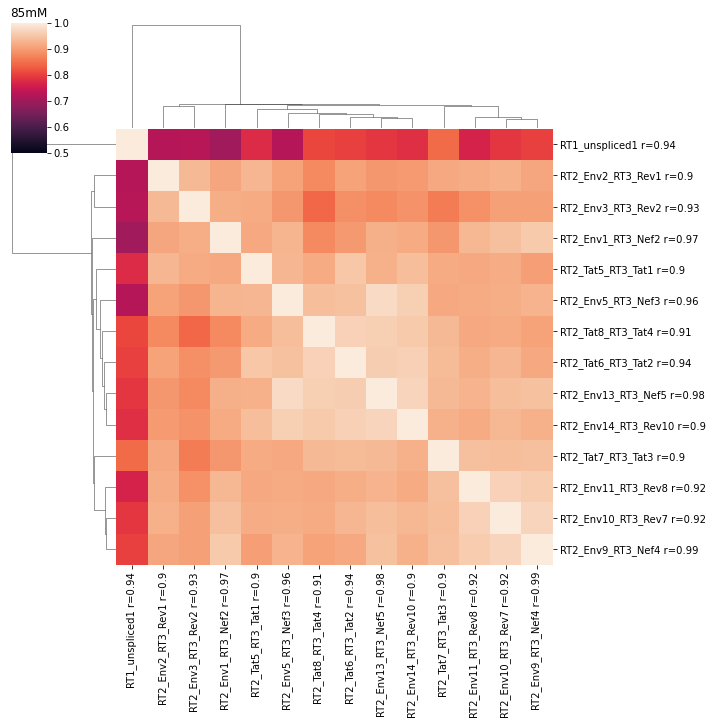

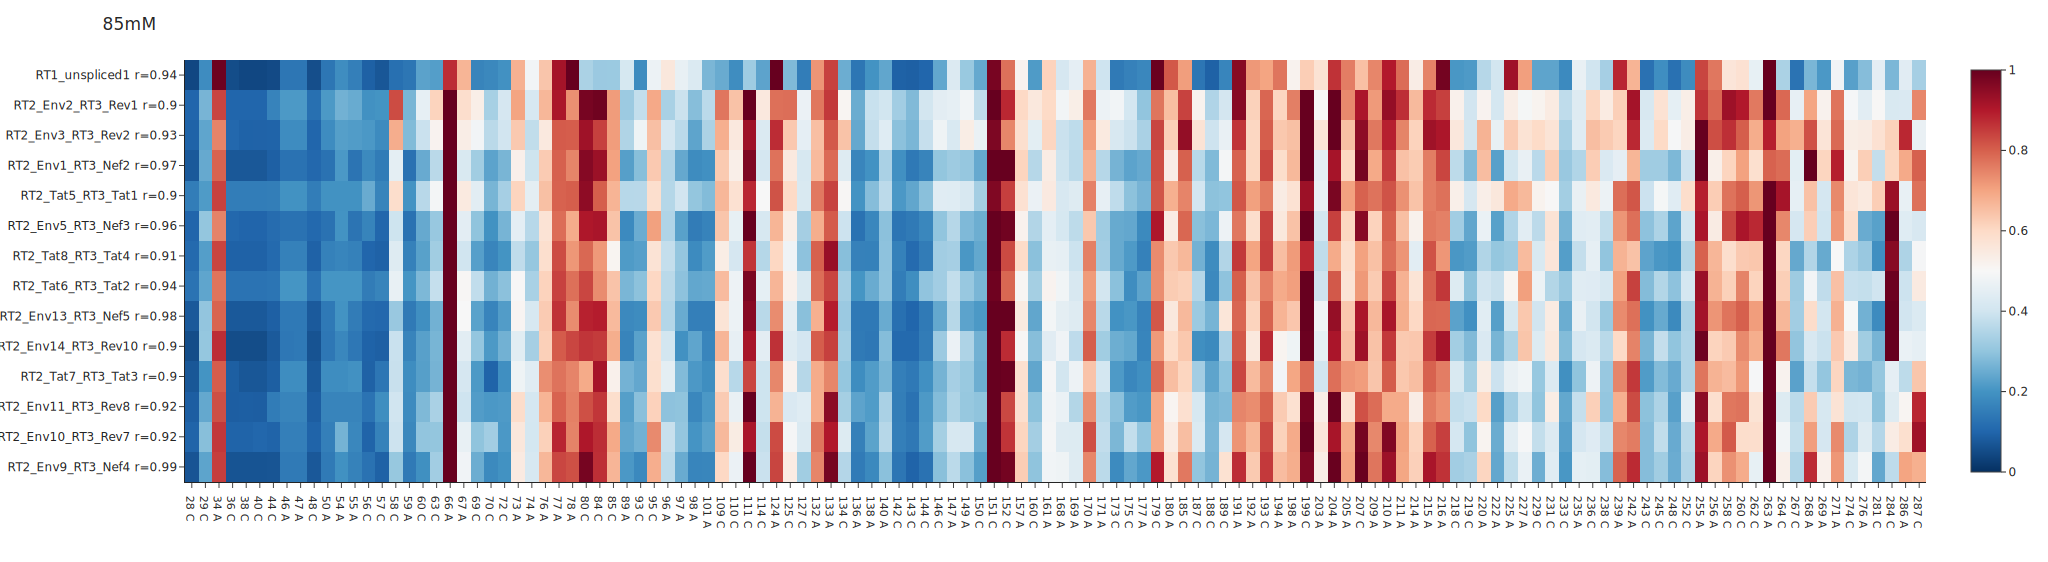

In [179]:
reactive_nt = "AC"
option = "q22_eq10_ndni"
norm_option= ""

end = 289

for conc in ["57mM", "85mM"]: #"8mM", "17mM", "34mM", "57mM"
    sub_df = filtered_df[filtered_df["DMS_conc"] == conc]
    isoform_names = sub_df["isoform"].values
    
    correlations = sub_df["pearson_corr"].values
    
    isoform_names = [f"{isoform_names[i]} r={np.round(correlations[i],2)}" for i in range(len(isoform_names))]
    RTs = sub_df["RT"].values
    
    ref = SeqIO.read(f"references/transcripts_PCR1_2_3/{isoform}.fa", "fasta")
    seq = np.array(list(ref.seq))

    reactivity_matrix = np.full((len(sub_df), end), fill_value=-1.0)
    row = 0
    sample_labels = []
    
    for i, (_, row) in enumerate(sub_df.iterrows()):
        reactivity = np.nan_to_num(row["reactivity"], nan=-1)
        reactivity_matrix[i, :] = reactivity[:end]

    nonnan_positions = np.where(~np.any(reactivity_matrix<0, axis=0))[0]
    nonnan_matrix = reactivity_matrix[:,nonnan_positions]
    
    nonnan_nt = seq[nonnan_positions]
    
    nt_labels = [f"{nonnan_positions[i]+1}\t{nonnan_nt[i]}" for i in range(len(nonnan_positions))]

    fig = clustermap(np.corrcoef(nonnan_matrix), xticklabels = [label.replace("\t", " ") for label in isoform_names], yticklabels = [label.replace("\t", " ") for label in isoform_names], method="single", vmin=0.5, vmax=1)
    plt.title(conc)
    plt.savefig(f"{figure_dir}/{conc}_{reactive_nt}_correlation.svg")
    
    plt.show()
    
    ordered_isoform_names = np.array(isoform_names)[fig.dendrogram_row.reordered_ind]
    
    reordered_matrix = nonnan_matrix[fig.dendrogram_row.reordered_ind, :]

    fig = px.imshow(reordered_matrix, y=ordered_isoform_names, x=nt_labels, zmin=0, aspect='auto', color_continuous_scale="RdBu_r")
    fig.update_layout(title=conc, height=100+33*len(ordered_isoform_names), width=16*len(nonnan_nt))
    fig.update_xaxes(tickfont_size=11)
    fig.write_image(f"{figure_dir}/{conc}_{reactive_nt}_heatmap.svg")
    
    fig.show(renderer="svg")

# Plot reactivity correlation across window

In [138]:
import bottleneck
def calc_win_correlation(reactivity1, reactivity2, window):
    nonnan_positions = np.where(np.all([reactivity1 >= 0, reactivity2 >= 0], axis=0))[0]
    corr = np.zeros(len(nonnan_positions), dtype=np.float64)
    for i in np.arange(len(nonnan_positions-window)):
        positions = nonnan_positions[i:i+window]
        corr[i] = np.corrcoef(x=reactivity1[positions], y=reactivity2[positions])[0][1]
    
    return nonnan_positions, corr

In [139]:
figure_dir = f"{os.getcwd()}/figures/reactivity_correlations"
os.makedirs(figure_dir, exist_ok=True)

/home/pbohn/miniconda3/envs/nanodms/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/pbohn/miniconda3/envs/nanodms/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning:

divide by zero encountered in divide

/home/pbohn/miniconda3/envs/nanodms/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning:

invalid value encountered in multiply



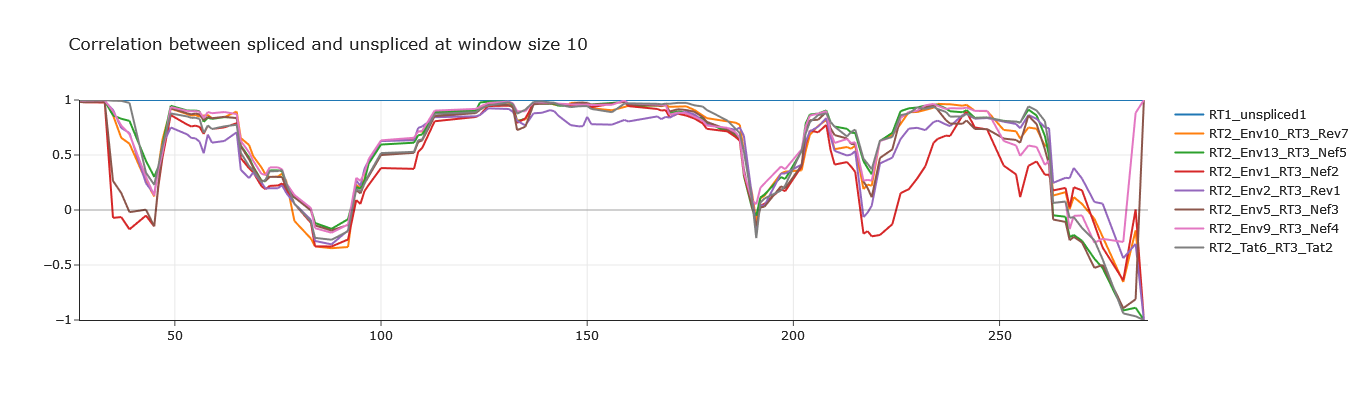

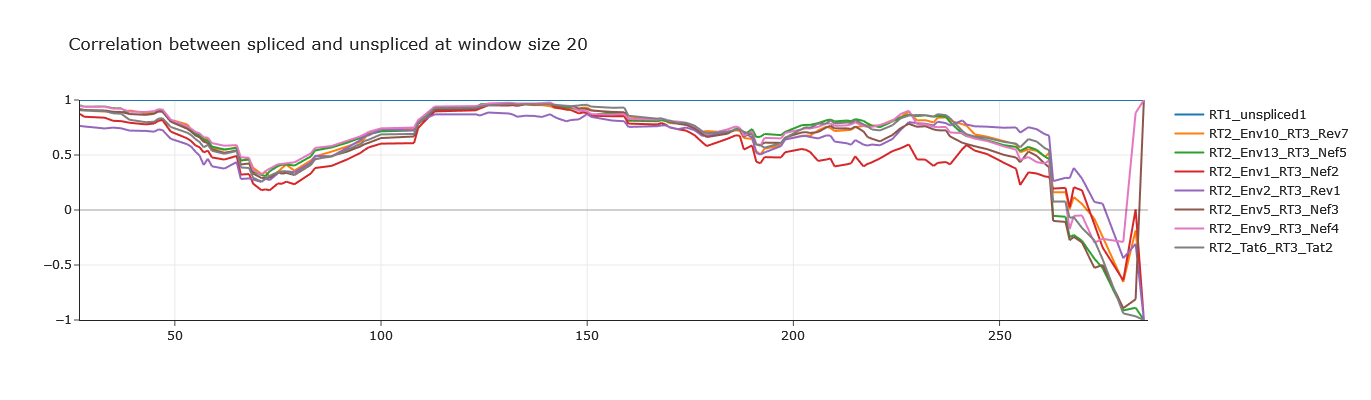

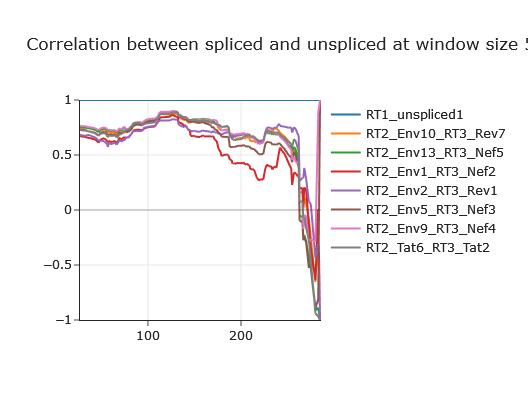

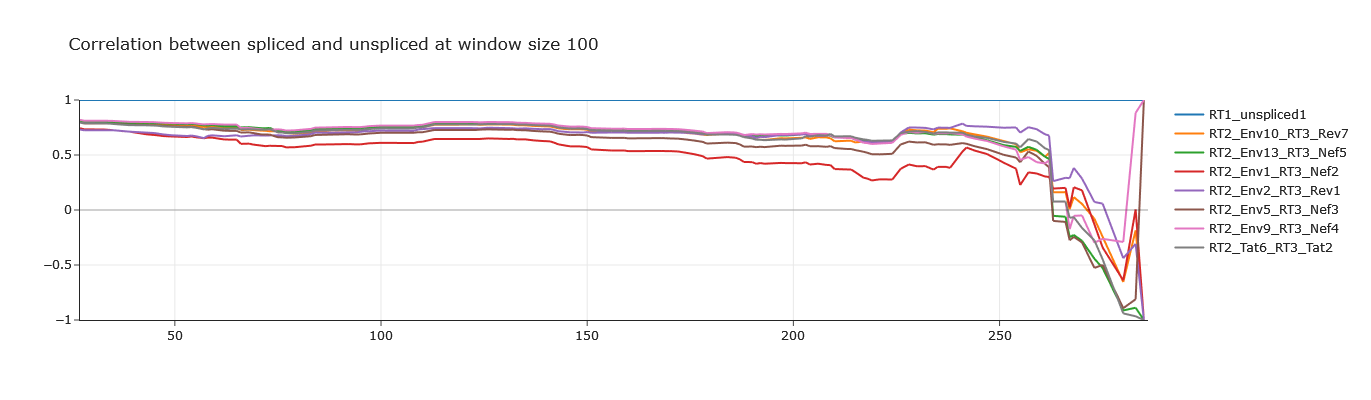

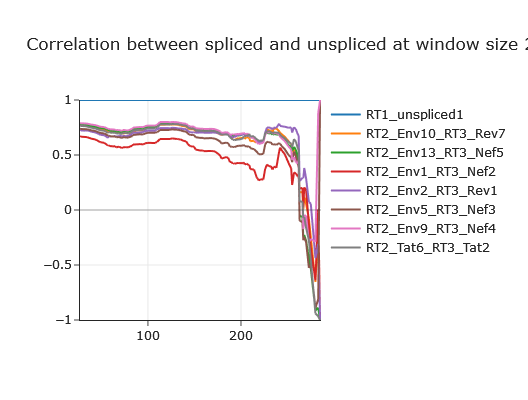

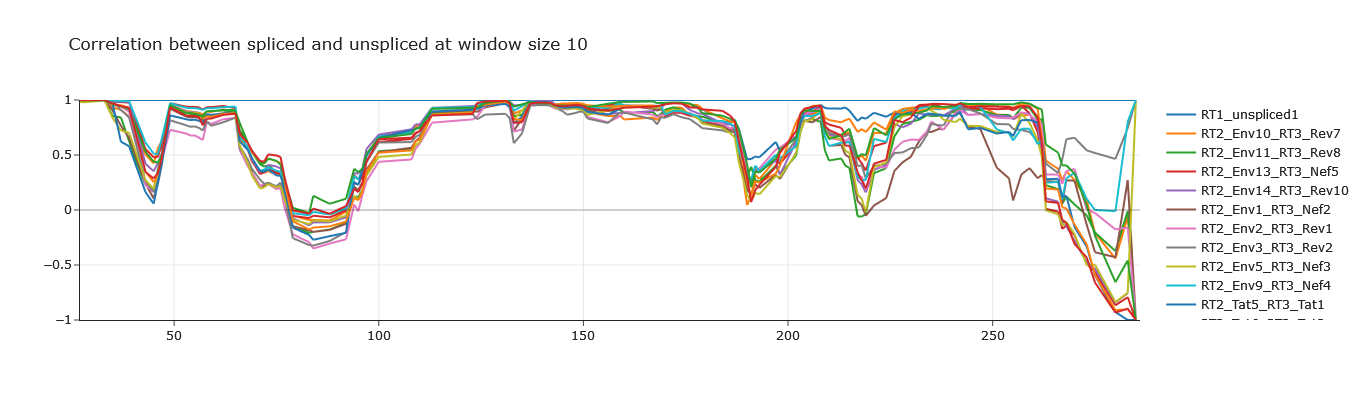

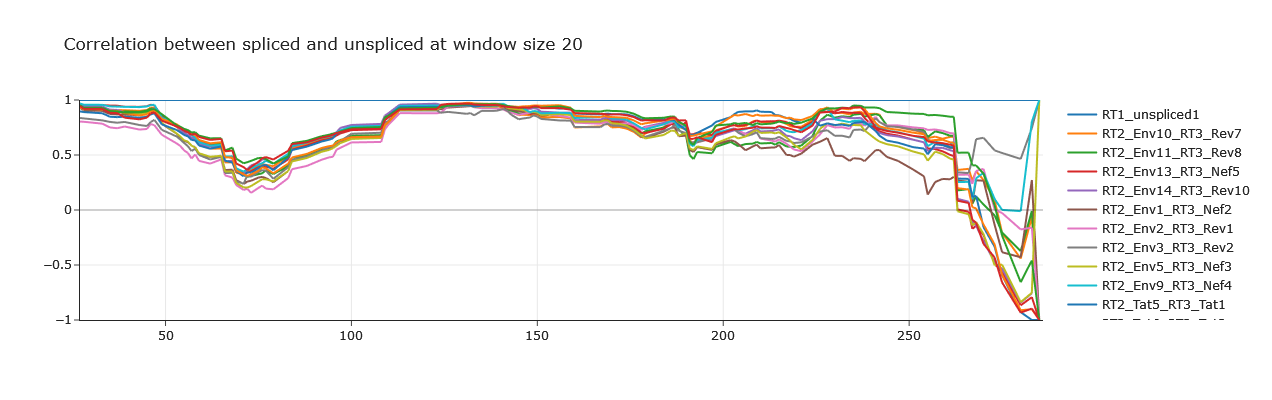

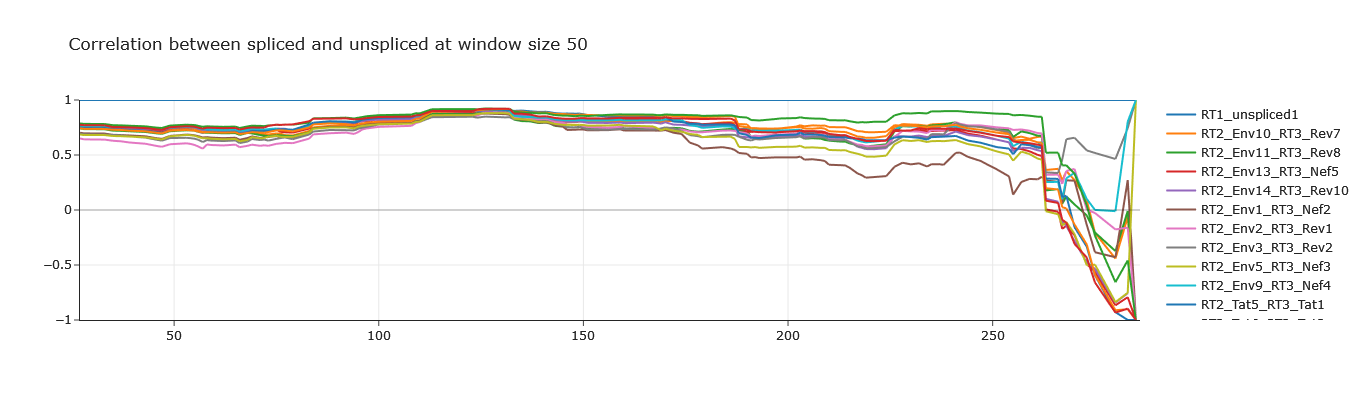

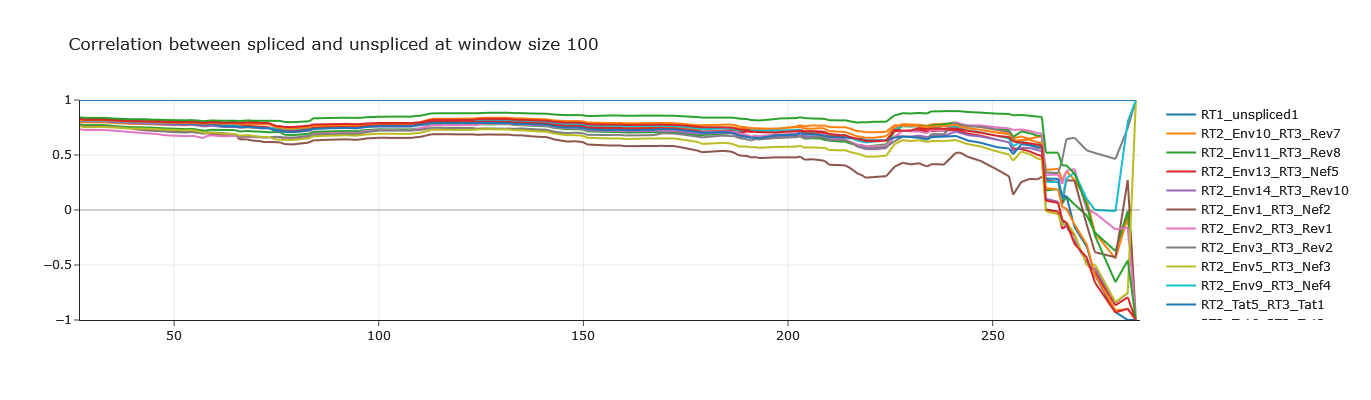

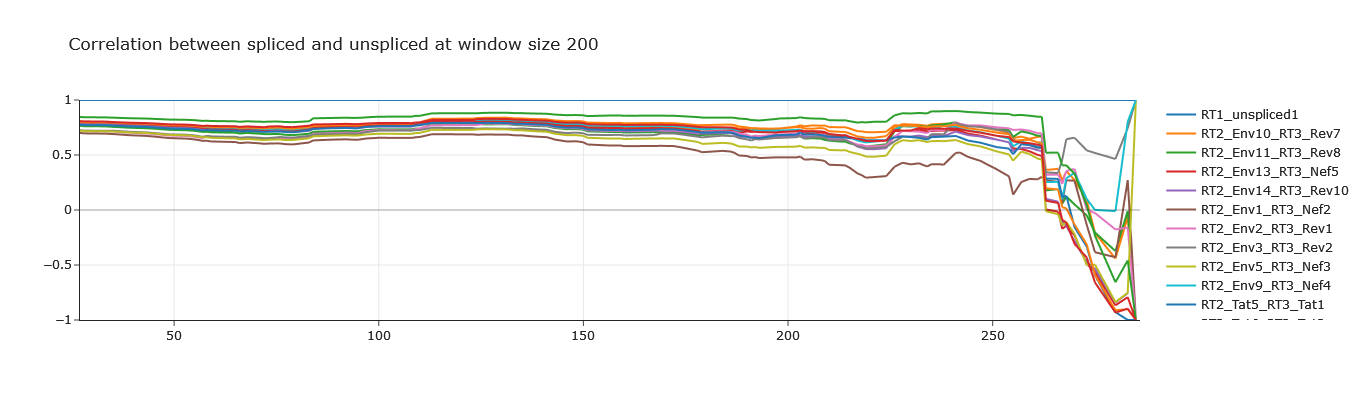

In [141]:
#tmp_data = []

#DMS conc
reactive_nt = "AC"
option = "q22_eq10_ndni"
norm_option= ""

end = 289

compare_isoform = "RT1_unspliced1"

for conc in ["57mM", "85mM"]: #"8mM", "17mM", "34mM", "57mM"
    sub_df = filtered_df[(filtered_df["DMS_conc"] == conc)]
    isoform_names = filtered_df["isoform"].values
    
    for window in [10, 20, 50, 100, 200]:
        fig = go.Figure()
        fig.update_layout(title = "Correlation between spliced and unspliced at window size " + str(window))
        
        reactivity1 = sub_df[sub_df["isoform"] == compare_isoform]["reactivity"].values[0][:end]
        for isoform in sub_df["isoform"].unique():
            reactivity2 = sub_df[sub_df["isoform"] == isoform]["reactivity"].values[0][:end]

            positions, corr = calc_win_correlation(reactivity1, reactivity2, window)
            fig.add_trace(go.Scattergl(x=positions, y=corr, name=f"{isoform}"))
            #tmp_data.append(["DMS_corr", mod, location, window, corr, positions])
        fig.update_yaxes(range=[-1,1])
        fig.add_hline(y=0, line_color="black", line_width=1)
        fig.update_layout(width=1200, height=400)
        fig.write_image(f"{figure_dir}/correlation_{conc}_win{window}.svg")
        fig.show(renderer="jupyterlab")



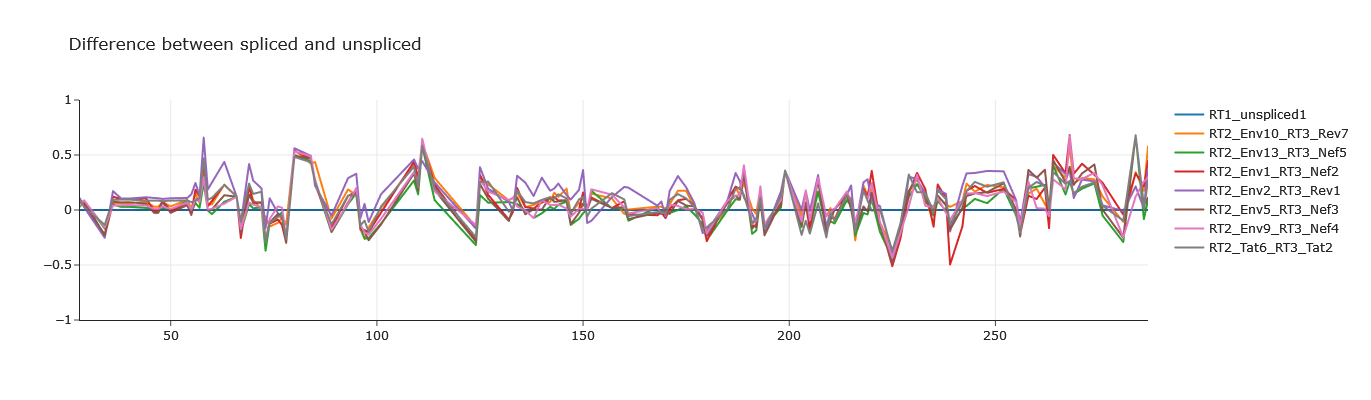

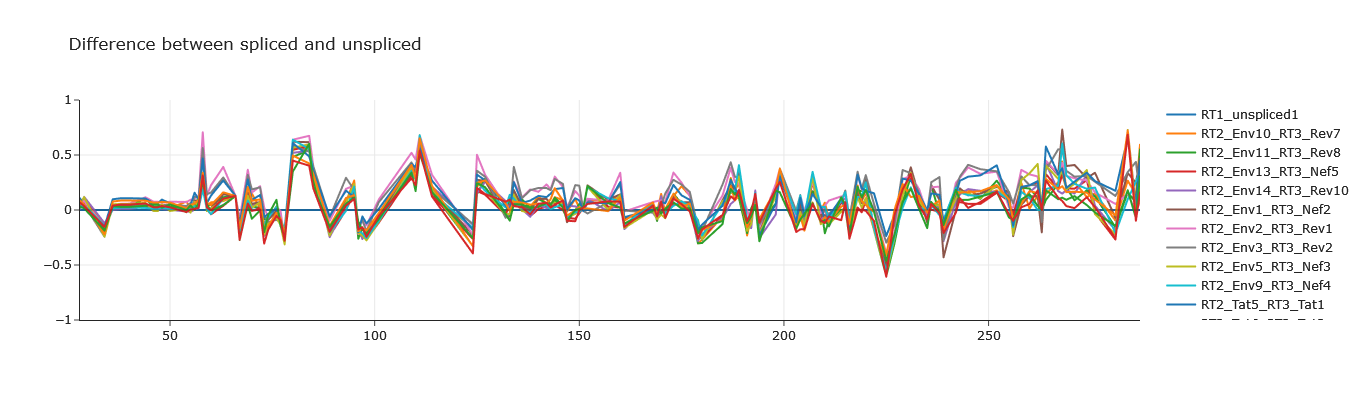

In [142]:
#tmp_data = []

#DMS conc
reactive_nt = "AC"
option = "q22_eq10_ndni"
norm_option= ""

end = 289

compare_isoform = "RT1_unspliced1"

for conc in ["57mM", "85mM"]: #"8mM", "17mM", "34mM", "57mM"
    sub_df = filtered_df[(filtered_df["DMS_conc"] == conc)]
    isoform_names = filtered_df["isoform"].values

    fig = go.Figure()
    fig.update_layout(title = "Difference between spliced and unspliced")

    reactivity1 = sub_df[sub_df["isoform"] == compare_isoform]["reactivity"].values[0][:end]
    for isoform in sub_df["isoform"].unique():
        reactivity2 = sub_df[sub_df["isoform"] == isoform]["reactivity"].values[0][:end]

        positions = np.where(np.all([reactivity1 > -1, reactivity2 > -1], axis=0))[0]
        diff_reactivity = reactivity2-reactivity1
        fig.add_trace(go.Scattergl(x=positions+1, y=diff_reactivity[positions], name=f"{isoform}"))
        #tmp_data.append(["DMS_corr", mod, location, window, corr, positions])
    fig.update_yaxes(range=[-1,1])
    fig.add_hline(y=0, line_color="black", line_width=1)
    fig.update_layout(width=1200, height=400)
    fig.write_image(f"{figure_dir}/correlation_{conc}_win{window}.svg")
    fig.show(renderer="jupyterlab")



# Fold RNAs

In [6]:
import os 

eternafold_dir = f"{os.getcwd()}/tools/EternaFold"
eternafold = f"{eternafold_dir}/src/contrafold"
!{eternafold}


Usage: contrafold [predict|predict-foldchange|sample|revi|train|em-train] [OPTION]... INFILE(s)

       where [OPTION]...   is a list of zero or more optional arguments
             INFILE(s)     is the name of the input BPSEQ, plain text, or FASTA file(s)

Miscellaneous arguments:
  --version                display program version information
  --verbose                show detailed console output
  --logbase LOG_BASE       set base of log-sum-exp
  --viterbi                use Viterbi instead of posterior decoding for prediction, 
                           or max-margin instead of log-likelihood for training
  --noncomplementary       allow non-{AU,CG,GU} pairs

Additional arguments for 'predict' mode:
  --params FILENAME        use particular model parameters
  --constraints            use existing constraints (requires BPSEQ or FASTA format input)
  --evidence               use experimental evidence (requires BPSEQ format input)
  --centroid               use centroid estimator (

In [5]:
from tools.python_functions.xml_conversions import read_in_xml, convert_xml_to_bpseq, convert_xml_to_bpseq_trimmed
from tools.python_functions.struct_pred import generate_db_from_eterna, generate_varna

In [149]:
sample_isoforms_w_hq_data = filtered_df.groupby("sample").agg({"isoform_id" : list}).to_dict()["isoform_id"]

{'RT-FS_57mM': ['RT2_Env10_RT3_Rev7',
  'RT2_Env13_RT3_Nef5',
  'RT2_Env1_RT3_Nef2',
  'RT2_Env2_RT3_Rev1',
  'RT2_Env5_RT3_Nef3',
  'RT2_Env9_RT3_Nef4',
  'RT2_Tat6_RT3_Tat2'],
 'RT-FS_85mM': ['RT2_Env10_RT3_Rev7',
  'RT2_Env11_RT3_Rev8',
  'RT2_Env13_RT3_Nef5',
  'RT2_Env14_RT3_Rev10',
  'RT2_Env1_RT3_Nef2',
  'RT2_Env2_RT3_Rev1',
  'RT2_Env3_RT3_Rev2',
  'RT2_Env5_RT3_Nef3',
  'RT2_Env9_RT3_Nef4',
  'RT2_Tat5_RT3_Tat1',
  'RT2_Tat6_RT3_Tat2',
  'RT2_Tat7_RT3_Tat3',
  'RT2_Tat8_RT3_Tat4'],
 'RT-US_57mM': ['RT1_unspliced1'],
 'RT-US_85mM': ['RT1_unspliced1']}

In [155]:
rf_norm_dir = f"{data_folder}/rfcombine"
eterna_dir = f"{data_folder}/eterna_out/"
os.makedirs(eterna_dir, exist_ok=True)

start = 0
end = "full"

mask_PBS = False
mask_DIS = False
primer_5 = 26

from slurmpy import Slurm
num_threads = 1

eterna_slurm = Slurm("eternafold", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : num_threads, "time" : "600"})
    
rfcount_option = "q22_eq10_ndni"
nt="AC"

for sample, isoform_list in sample_isoforms_w_hq_data.items():
    for isoform in isoform_list:
        bp2seq_file = f"{rf_norm_dir}/{sample}/{isoform}/{rfcount_option}_{nt}/{isoform}.bp2seq"

        db_outfolder = f"{eterna_dir}/{sample}/"
        os.makedirs(db_outfolder, exist_ok=True)
        eterna_outfile = f"{db_outfolder}/{sample}_{isoform}_predict_out.eterna"

        command = f"{eternafold} predict {bp2seq_file} --evidence --numdatasources 1 --params {eternafold_dir}/parameters/EternaFoldParams_PLUS_POTENTIALS.v1 > {eterna_outfile}"
        eterna_slurm.run(command)


b'Submitted batch job 1197919'
b'Submitted batch job 1197920'
b'Submitted batch job 1197921'
b'Submitted batch job 1197922'
b'Submitted batch job 1197923'
b'Submitted batch job 1197924'
b'Submitted batch job 1197925'
b'Submitted batch job 1197926'
b'Submitted batch job 1197927'
b'Submitted batch job 1197928'
b'Submitted batch job 1197929'
b'Submitted batch job 1197930'
b'Submitted batch job 1197931'
b'Submitted batch job 1197932'
b'Submitted batch job 1197933'
b'Submitted batch job 1197934'
b'Submitted batch job 1197935'
b'Submitted batch job 1197936'
b'Submitted batch job 1197937'
b'Submitted batch job 1197938'
b'Submitted batch job 1197939'
b'Submitted batch job 1197940'


In [156]:
eterna_dir = f"{data_folder}/eterna_out/"
start = 0
end = "full"

# to run Varna from command line it needs to be in the current working directory

for sample, isoform_list in sample_isoforms_w_hq_data.items():
    for isoform in isoform_list:
        xml_file = f"{rf_norm_dir}/{sample}/{isoform}/{rfcount_option}_{nt}/{isoform}.xml"

        db_outfolder = f"{eterna_dir}/{sample}/"
        os.makedirs(db_outfolder, exist_ok=True)
        eterna_outfile = f"{db_outfolder}/{sample}_{isoform}_predict_out.eterna"

        db_files = generate_db_from_eterna(eterna_outfile, sample, db_outfolder, xml_file, mode="predict", start = start, end = end)

        for db_file in db_files:
            varna_outprefix = f"{db_outfolder}/{db_file.split('/')[-1].split('.db')[0]}"
            generate_varna(db_file, xml_file, sample, varna_outprefix, primer_5 = 28, primer_3 = 25)

Output file: /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/_protocol_example_run/data/eterna_out//RT-FS_57mM//RT-FS_57mM_RT2_Env10_RT3_Rev7_predict_out_radiate.varna

Output file: /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/_protocol_example_run/data/eterna_out//RT-FS_57mM//RT-FS_57mM_RT2_Env10_RT3_Rev7_predict_out_line.varna

Output file: /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/_protocol_example_run/data/eterna_out//RT-FS_57mM//RT-FS_57mM_RT2_Env13_RT3_Nef5_predict_out_radiate.varna

Output file: /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/_protocol_example_run/data/eterna_out//RT-FS_57mM//RT-FS_57mM_RT2_Env13_RT3_Nef5_predict_out_line.varna

Output file: /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/_protocol_example_run/data/eterna_out//RT-FS_57mM//RT-FS_57mM_RT2_Env1_RT3_Nef2_predict_out_radiate.varna

Output file: /vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/_protocol_example_run/data/eterna_out//RT-FS_57mM//RT-FS_57mM_RT2_Env1_RT3_Nef2_predict_o